In [1]:
%load_ext autoreload
%autoreload 2
%cd ~/pytorch-tutorial/pyro

/home/ecotner/pytorch-tutorial/pyro


Recall that exponential growth $y(t) = y(t_0) \exp\left[\gamma(t - t_0)\right]$ can be described by the differential equation $\dot{y} = \gamma y$. We can easily turn this into a finite-difference recurrence relation:
$$
y_{t+1}= (1 + \gamma\, \Delta t) y_t = (1 + r) y_t
$$
where $r = \gamma\, \Delta t > 0$ is the rate of increase between each successive step $t \rightarrow t+1$. If we are given some noisy sequential data $y_t$, then we can perform inference to estimate the distribution of $r$. However, let us assume that rather than a single fixed value of $r$, this quantity is sampled from some distribution $R$ at each time step so that $r \rightarrow r_t \sim R$. Our model is therefore
$$
y_{t+1} = (1 + r_t) y_t
$$
where $r_t$ is just the sample value of $r$ at time $t$. We can invert this relationship to get $r_t$ directly:
$$
r_t = (y_{t+1}/y_t) - 1,
$$
but what if we want to complicate our model in the future with extra terms to capture more effects? The model will in general not be invertible, so how do we _infer_ the distribution $R$? Let's use Bayesian inference!

In [2]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as st

import torch
import torch.tensor as tt
from torch.distributions import constraints as tconst
import pyro
from pyro.distributions import Normal, Gamma, Delta, Uniform, Exponential, TransformedDistribution
from pyro.distributions.transforms import AffineTransform, ExpTransform, AbsTransform
import pyro.infer
from pyro.infer import MCMC, NUTS
import pyro.optim

In [93]:
class SVIModel:
    """
    This models the system of equations y_{i+1} = (1+r)*y_i, where r ~ Gamma(k, theta).
    The object is to perform inference and reconstruct the distribution of r using SVI
    (which means recovering the parameters k and theta).
    """
    def __init__(self, k, theta):
        # Specify the parameters of the prior, and also the starting
        # values of the variational parameters
        self.k = torch.tensor(float(k))
        self.theta = torch.tensor(float(theta))

    def model(self, y):
        N = len(y) - 1
        # K and theta are variational parameters, but we still need to "sample" them
        k = pyro.sample("k_", Delta(self.k))
        theta = pyro.sample("theta_", Delta(self.theta))
        with pyro.plate("data", N):
            # Now we need to specify the distribution of the target in terms
            # of a sequence of transformed distributions
            X, Y = torch.log(y[:-1]), torch.log(y[1:])
            Yhat = TransformedDistribution(
                Gamma(k, 1/theta), # The original distribution for r
                [
                    AffineTransform(1., 1.), # 1+r
                    ExpTransform().inv,      # log(1+r)
                    AffineTransform(X, 1.)   # log(1+r) + log(y_i)
                ]
            )
            obs = pyro.sample("obs", Yhat, obs=Y)

    def guide(self, y):
        N = len(y) - 1
        k = pyro.param("k", self.k, constraint=tconst.positive)
        theta = pyro.param("theta", self.theta, constraint=tconst.positive)
        # Even though k and theta aren't random variables, we still need
        # to sample them so the guide knows it needs to optimize them
        pyro.sample("k_", Delta(k))
        pyro.sample("theta_", Delta(theta))

    def r(self, N=1):
        # Useful for sampling from the posterior of r
        k = pyro.param("k", self.k, constraint=tconst.positive)
        theta = pyro.param("theta", self.theta, constraint=tconst.positive)
        return Gamma(k, 1/theta).sample([N])

In [94]:
## Generate dataset
K, THETA = 3e0, 1e-1
def gen_ts(k, theta, T=10):
    y0 = 1
    Y = [y0]
    for t in range(T):
        y0 = (1 + random.gammavariate(k, theta))*y0
        Y.append(y0)
    return torch.tensor(Y)

# data = [gen_ts(K, THETA, T) for T in np.random.uniform(1, 10, size=100).round().astype(int)]
Y = gen_ts(K, THETA, 100)

pyro.enable_validation(True)
pyro.clear_param_store()
model = SVIModel(2, 0.5)
svi = pyro.infer.SVI(
    model=model.model,
    guide=model.guide,
    optim=pyro.optim.Adam({"lr": 1e-2, "betas": (0.9, 0.9)}),
    loss=pyro.infer.Trace_ELBO()
)

num_steps = 300
pbar = tqdm.notebook.tqdm(total=num_steps, mininterval=1)
loss = []
ps = pyro.get_param_store()
params = dict()
alpha = 0.9
for i in range(num_steps):
    loss.append(svi.step(Y))
    if i == 0 or np.isinf(avg_loss):
        avg_loss = loss[-1]
    else:
        avg_loss = alpha * avg_loss + (1-alpha) * loss[-1]
    for k in ps.keys():
        try:
            params[k].append(ps[k].item())
        except KeyError:
            params[k] = [ps[k].item()]
    pbar.set_description(f"loss={avg_loss: 5.2e}")
    pbar.update()
pbar.close()

In [95]:
", ".join([f"{k}={v[-1]}" for k, v in params.items()])

'k=2.8454227447509766, theta=0.10501875728368759'

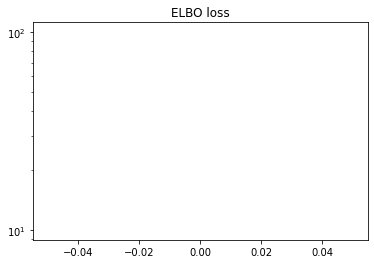

In [96]:
plt.plot(loss)
plt.title("ELBO loss")
plt.yscale('log')
plt.show()

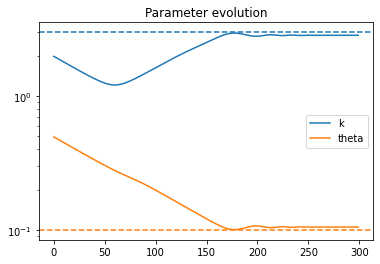

In [97]:
for k, v in params.items():
    plt.plot(v, label=k)
plt.axhline(K, color='C0', linestyle="--")
plt.axhline(THETA, color="C1", linestyle="--")
plt.yscale('log')
plt.title("Parameter evolution")
plt.legend()
plt.savefig("parameter_evolution.png", bbox_inches="tight", dpi=100)
plt.show()

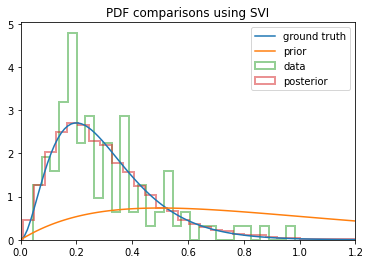

In [98]:
plt.xlim(0, 1.2)
# Ground-truth distribution
x = np.linspace(0, 1.2, 100)
y = st.gamma(a=K, scale=THETA).pdf(x)
plt.plot(x, y, label="ground truth")
# Prior distribution
x = np.linspace(0, 1.2, 100)
y = st.gamma(a=model.k.item(), scale=model.theta.item()).pdf(x)
plt.plot(x, y, label="prior")
# Sample distribution
X = ((torch.roll(Y, -1) - Y)/Y).numpy()[:-1]
plt.hist(X, bins=30, alpha=0.5, label="data", density=True, histtype='step', linewidth=2)
# The posterior distribution
x = model.r(10000).numpy()
plt.hist(x[x<1.2], bins=30, alpha=0.5, label="posterior", density=True, histtype='step', linewidth=2)

plt.legend()
plt.title("PDF comparisons using SVI")
plt.savefig("svi_distributions.png", bbox_inches="tight", dpi=100)
plt.show()

## Now do the same thing for HMC

In [9]:
class HMCModel:
    """
    This models the system of equations y_{i+1} = (1+r)*y_i, where r ~ Gamma(k, theta).
    The object is to perform inference and reconstruct the distribution of r using HMC (NUTS).
    This actually means recovering the posterior of the parameters of the gamma distribution
    which determines r.
    """
    def __init__(self, k, theta):
        # Specify the parameters of the prior
        self.k = torch.tensor(float(k))
        self.theta = torch.tensor(float(theta))

    def model(self, y):
        N = len(y) - 1
        # Sample from the hyperpriors for r
        alpha = abs(pyro.sample("k", Uniform(0, 4)))
        beta = 1/abs(pyro.sample("theta", Uniform(0, 3)))
        with pyro.plate("data", N):
            # Now we need to specify the distribution of the target in terms
            # of transformed distributions
            r = Gamma(alpha, beta) # The original distribution for r
            x = TransformedDistribution(r, AffineTransform(1., 1.)) # 1+r
            x = TransformedDistribution(x, ExpTransform().inv) # log(1+r)
            X, Y = torch.log(y[:-1]), torch.log(y[1:])
            Yhat = TransformedDistribution(x, AffineTransform(X, 1.)) # log(1+r) + log(y_i)
            obs = pyro.sample("obs", Yhat, obs=Y)

In [14]:
## Generate dataset
K, THETA = 3e0, 1e-1
def gen_ts(k, theta, T=10):
    y0 = 1
    Y = [y0]
    for t in range(T):
        y0 = (1 + random.gammavariate(k, theta))*y0
        Y.append(y0)
    return torch.tensor(Y)

Y = gen_ts(K, THETA, 100)

pyro.enable_validation(True)
model = HMCModel(2, 2)

nuts_kernel = NUTS(
    model.model,
    adapt_step_size=True,
    adapt_mass_matrix=True,
    jit_compile=False,
    full_mass=True
)
mcmc = MCMC(
    nuts_kernel,
    num_samples=2000,
    warmup_steps=1000,
    num_chains=1
)
mcmc.run(Y)
samples = mcmc.get_samples()

Sample: 100%|██████████| 3000/3000 [00:29, 103.11it/s, step size=6.79e-01, acc. prob=0.914]


In [15]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      2.79      0.36      2.78      2.22      3.41    596.68      1.00
     theta      0.10      0.01      0.10      0.07      0.12    664.69      1.00

Number of divergences: 0


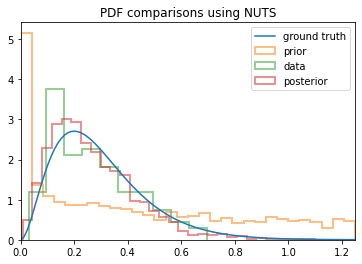

In [16]:
plt.xlim(left=0, right=1.25)
# Ground-truth distribution
x = np.linspace(0, 1.25, 100)
y = st.gamma(a=K, scale=THETA).pdf(x)
plt.plot(x, y, label="ground truth")
# # Prior distribution
k = st.uniform(0, 4).rvs(5000)
th = st.uniform(0, 3).rvs(5000)
x = st.gamma(a=k, scale=th).rvs()
x = x[x<1.25]
plt.hist(x, bins=30, density=True, histtype='step', alpha=0.5, label="prior", linewidth=2)
# Data distribution
X = ((torch.roll(Y, -1) - Y)/Y).numpy()[:-1]
plt.hist(X, bins=10, alpha=0.5, label="data", density=True, histtype='step', linewidth=2)
# Posterior samples
k = abs(samples['k']).flatten().numpy()
th = abs(samples['theta']).flatten().numpy()
x = np.array([st.gamma(a=k_, scale=th_).rvs() for k_, th_ in zip(k, th)])
x = x[x<1.25]
plt.hist(x, bins=30, alpha=0.5, label="posterior", density=True, histtype='step', linewidth=2)

plt.legend()
plt.title("PDF comparisons using NUTS")
plt.savefig("nuts_distributions.png", bbox_inches='tight', dpi=100)
plt.show()